In [179]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [180]:
import os
import numpy as np
import pandas as pd

import re

#pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore',category=FutureWarning)

In [181]:
DATASET_ROOT = '/content/drive/MyDrive/機械学習/Competitions/Signate/SOTA [住宅予測]'
INPUT_DIR = os.path.join(DATASET_ROOT,'input')
train = pd.read_csv(os.path.join(INPUT_DIR,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'))
train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [182]:
print('train missing count : ',train.isnull().sum().sum())
print('test missing count : ',test.isnull().sum().sum())

train missing count :  29060
test missing count :  28869


In [183]:
train.isnull().sum()    

id           0
賃料           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2749
面積           0
所在階          0
バス・トイレ     329
キッチン       621
放送・通信     3440
室内設備        82
駐車場       5287
周辺環境      9432
建物構造         0
契約期間      7120
dtype: int64

In [184]:
test.isnull().sum()

id           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2808
面積           0
所在階          1
バス・トイレ     320
キッチン       635
放送・通信     3454
室内設備        73
駐車場       5356
周辺環境      9241
建物構造         0
契約期間      6981
dtype: int64

In [185]:
target = '賃料'

In [186]:
train.describe()

,id,賃料
count,31470.000000,3.147000e+04
mean,15735.500000,1.182903e+05
std,9084.750822,7.374880e+04
min,1.000000,2.500000e+04
25%,7868.250000,7.600000e+04
50%,15735.500000,1.020000e+05
75%,23602.750000,1.360000e+05
max,31470.000000,2.500000e+06


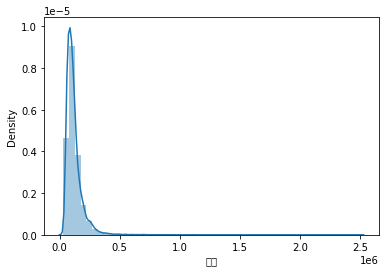

In [187]:
sns.distplot(train[target])

In [188]:
print('歪度 : %f' %train[target].skew())
print('尖度 : %f' %train[target].kurt())

歪度 : 5.735686
尖度 : 85.553349


In [189]:
#ミス入力らしい
train[target] = np.where(train['id']==5776, 120350, train[target])

In [190]:
train.query('id==5776')

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
5775,5776,120350,東京都港区新橋４丁目,山手線\t新橋駅\t徒歩2分\t\t都営大江戸線\t汐留駅\t徒歩2分,1K,12年5ヶ月,北西,20.53m2,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 570m\t【コンビニ】 43m\t【コンビニ】 2...,RC（鉄筋コンクリート）,2年間


歪度 : 0.648496
尖度 : 1.096282


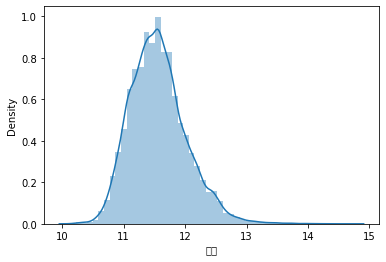

In [191]:
target_log = np.log(train[target])

print('歪度 : %f' %target_log.skew())
print('尖度 : %f' %target_log.kurt())

sns.distplot(target_log)

In [192]:
train[target] = np.log(train[target])

In [193]:
Price_log = train[target]

In [194]:
train.drop(target,axis=1,inplace=True)

In [195]:
all_df = pd.concat([train,test],axis=0,ignore_index=True)
print(train.shape,test.shape)
print(all_df.shape)
print(train.shape[0]+test.shape[0])

(31470, 16) (31262, 16)
(62732, 16)
62732


In [196]:
train_length = train.shape[0]
test_length = test.shape[0]
print(train_length)
print(test_length)

31470
31262


In [197]:
df = all_df.rename(columns={'契約期間':'Contract', '間取り':'Room', '築年数':'Passed', 
                            '駐車場':'Parking', '室内設備':'Facility', '放送・通信':'Internet', 
                            '周辺環境':'Building', '建物構造':'Material', '面積':'Area', 
                            'キッチン':'Kitchen', '所在地':'Place', 'バス・トイレ':'Bath', 
                            '所在階':'Floor', 'アクセス':'Access', '方角':'Angle'})

In [198]:
df.head()

,id,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract
0,1,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [199]:
#ミスがあるらしいので変更しとく
def modify_miss(df_input):
    df_input.loc[df_input['Room'].str.contains('11R'), 'Room'] = '1R'
    
    df_input.loc[df_input['Passed'].str.contains('520年5ヶ月'), 'Passed'] = '52年5ヶ月'
    
    df_input.loc[df_input['Passed'].str.contains('1019年7ヶ月'), 'Passed'] = '19年7ヶ月'
    
    df_input.loc[df_input['Area']=='430.1m2', 'Area'] = '43.01m2'
    
    df_input.loc[df_input['Area']==('1m2'), 'Area'] = '10m2'
    
    df_input.loc[df_input['Area']==('5.83m2'), 'Area'] = '58.3m2'
    
    '三田線 三田(兵庫県)駅 徒歩14分'
    
    return df_input

df = modify_miss(df)

In [200]:
#おそらくやるならtrain,testごと
def count_encoding(df,col):
  out_df = pd.DataFrame()
  temp = df[col].value_counts().to_dict()
  out_df[f'count_{col}'] = df[col].map(temp)
  return out_df

In [201]:
def makeCountFull(df,categorical_features=None,report=None):
  add_cols = categorical_features
  if report:
    print('add_cols:',add_cols)
  for add_col in add_cols:
    df[add_col + '_countall'] = df[add_col].map(df[add_col].value_counts(dropna=False))
  return df

cat_features = ['Place', 'Access', 'Room', 'Passed', 'Angle', 'Area', 'Floor', 'Bath', 'Kitchen', 'Internet', 'Facility', 'Parking', 'Building', 'Material', 'Contract']
df = makeCountFull(df,cat_features)

In [202]:
df['納戸'] = [1 if '納戸' in i else 0 for i in df['Room']]

In [203]:
df.rename(columns={'納戸':'Strage_Room'},inplace=True)

In [204]:
df['count_Room'] = [int(re.sub('[^0-9]','',i)) for i in df['Room']]

In [205]:
df['count_Room'] = np.where(df['count_Room']>4,5,df['count_Room'])

In [206]:
df['Room'] = [re.sub('[0-9S(納戸)\+]','',i) for i in df['Room']]

In [207]:
df['Place_ku'] = [i.split('区')[0] + '区' for i in df['Place']]

In [208]:
df['Place_ku_countall'] = df['Place_ku'].map(df['Place_ku'].value_counts(dropna=False))

In [209]:
df['Area'] = [re.sub('m2','',i) for  i in df['Area']]

In [210]:
df['Area'] = df['Area'].astype('float')

In [211]:
df['Num_of_Null'] = df.isnull().sum(axis=1)

In [212]:
df['Building_element_count'] = df['Building'].str.count('【').fillna(0)
df['Facility_element_count'] = df['Facility'].str.count('\t').fillna(-1)+1
df['Kitchen_element_count'] = df['Kitchen'].str.count('\t').fillna(-1)+1
df['Bath_element_count'] = df['Bath'].str.count('\t').fillna(-1)+1
df['Internet_element_count'] = df['Internet'].str.count('\t').fillna(-1)+1

In [213]:
df['Contract_imp'] = 0
df.loc[((df['Contract']=='1年間') | (df['Contract']=='1年間\t※この物件は\t定期借家\tです。')),'Contract_imp'] = 1
df.loc[((df['Contract']=='2年間') | (df['Contract']=='2年間\t※この物件は\t定期借家\tです。')),'Contract_imp'] = 2
df.loc[((df['Contract']=='3年間') | (df['Contract']=='3年間\t※この物件は\t定期借家\tです。')),'Contract_imp'] = 3

In [214]:
df.loc[df['Passed']=='新築','Passed'] = '0年0ヶ月'

In [215]:
df['Passed_year'] = [i.split('年')[0] for i in df['Passed']]
df['Passed_month'] = [i.split('年')[1] for i in df['Passed']]

In [216]:
df['Passed_year'] = df['Passed_year'].astype('int')
df['Passed_month'] =[re.sub('ヶ月','',i) for  i in df['Passed_month']]
df['Passed_month'] = df['Passed_month'].astype('int')

In [217]:
df['Passed_all_month'] = df['Passed_year'] * 12 + df['Passed_month']

In [218]:
df['Passed_year_Countall'] = df['Passed_year'].map(df['Passed_year'].value_counts(dropna=False))

In [219]:
df['Floor'] = df['Floor'].fillna('0階／0階建')
df['Building_floor'] = [i.split('／')[0] for i in df['Floor']] 
df['Building_story'] = [i.split('／')[-1] for i in df['Floor']]

In [220]:
df['Building_floor'] = df['Building_floor'].replace('','0階')
df['Building_floor'] = [i.split('階')[0] for i in df.Building_floor]
df['Building_story'] = [i.split('階建')[0] for i in df.Building_story]

In [221]:
df['Building_story'] = [i.split('階')[0] for i in df.Building_story]

In [222]:
df['Building_floor'] = [i.replace('地下','-') for i in df.Building_floor]

In [223]:
df['Building_floor'] = df['Building_floor'].astype(np.int64)
df['Building_story'] = df['Building_story'].astype(np.int64)

In [224]:
df['Have_UnderGround'] = [1 if '地下' in i else 0 for i in df['Floor']]

In [225]:
df['Building_floor_Countall'] = df['Building_floor'].map(df['Building_floor'].value_counts(dropna=False))
df['Building_story_Countall'] = df['Building_story'].map(df['Building_story'].value_counts(dropna=False))

In [226]:
df.isnull().sum()

id                             0
Place                          0
Access                         0
Room                           0
Passed                         0
Angle                       5557
Area                           0
Floor                          0
Bath                         649
Kitchen                     1256
Internet                    6894
Facility                     155
Parking                    10643
Building                   18673
Material                       0
Contract                   14101
Place_countall                 0
Access_countall                0
Room_countall                  0
Passed_countall                0
Angle_countall                 0
Area_countall                  0
Floor_countall                 0
Bath_countall                  0
Kitchen_countall               0
Internet_countall              0
Facility_countall              0
Parking_countall               0
Building_countall              0
Material_countall              0
Contract_c

In [227]:
df.head()

,id,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract,Place_countall,Access_countall,Room_countall,Passed_countall,Angle_countall,Area_countall,Floor_countall,Bath_countall,Kitchen_countall,Internet_countall,Facility_countall,Parking_countall,Building_countall,Material_countall,Contract_countall,Strage_Room,count_Room,Place_ku,Place_ku_countall,Num_of_Null,Building_element_count,Facility_element_count,Kitchen_element_count,Bath_element_count,Internet_element_count,Contract_imp,Passed_year,Passed_month,Passed_all_month,Passed_year_Countall,Building_floor,Building_story,Have_UnderGround,Building_floor_Countall,Building_story_Countall
0,1,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,K,9年9ヶ月,南東,20.01,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,18,1,23661,78,6150,73,16,1137,11953,1390,819,2473,1,34810,45052,0,1,東京都北区,2061,0,10.0,11.0,5.0,7.0,4.0,2,9,9,117,1062,1,12,0,12032,2631
1,2,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,R,44年10ヶ月,NaN,16.50,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,44,1,10178,37,5557,144,359,92,1116,5166,106,4853,1,7495,45052,0,1,東京都中央区,2532,1,1.0,9.0,4.0,3.0,1.0,2,44,10,538,283,5,10,0,3946,2978
2,3,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,K,8年6ヶ月,南,22.05,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,66,3,23661,131,17697,32,100,5785,11953,2041,259,37,3,34810,45052,0,1,東京都渋谷区,1978,0,4.0,13.0,5.0,9.0,4.0,2,8,6,102,992,12,15,0,661,1273
3,4,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,LDK,29年4ヶ月,南,60.48,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,1,1,5131,202,17697,7,1739,487,1885,3122,16,3603,1,34810,1888,0,2,東京都杉並区,3542,0,6.0,9.0,2.0,6.0,2.0,2,29,4,352,1580,3,4,0,10331,6165
4,5,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,DK,31年7ヶ月,南,39.66,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,1,1,3715,141,17697,49,5519,390,29,6894,10,9,1,11062,45052,0,2,東京都葛飾区,2387,1,5.0,5.0,2.0,5.0,0.0,2,31,7,379,1328,1,2,0,12032,12312


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62732 entries, 0 to 62731
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62732 non-null  int64  
 1   Place                    62732 non-null  object 
 2   Access                   62732 non-null  object 
 3   Room                     62732 non-null  object 
 4   Passed                   62732 non-null  object 
 5   Angle                    57175 non-null  object 
 6   Area                     62732 non-null  float64
 7   Floor                    62732 non-null  object 
 8   Bath                     62083 non-null  object 
 9   Kitchen                  61476 non-null  object 
 10  Internet                 55838 non-null  object 
 11  Facility                 62577 non-null  object 
 12  Parking                  52089 non-null  object 
 13  Building                 44059 non-null  object 
 14  Material              

In [229]:
df.Parking.value_counts().head(10)

駐車場\t無                                      6392
駐輪場\t空有\t駐車場\t無\tバイク置き場\t無                  4853
駐車場\t無\t駐輪場\t無\tバイク置き場\t無                   3603
駐輪場\t空有                                     2473
駐輪場\t空有\tバイク置き場\t無                          1931
駐輪場\t無\tバイク置き場\t無                           1914
駐輪場\t空有\tバイク置き場\t空有                         1509
駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無                 1222
駐輪場\t空有\t0円                                  902
駐車場\t空有\t32,400円(税込)\t駐輪場\t空有\tバイク置き場\t無     278
Name: Parking, dtype: int64

In [230]:
def clean_parking(text):
    obj = ["駐車場", "バイク置き場", "駐輪場"]
    if type(text)==float:
        return np.full(3, np.nan)
    else:
        text_list = text.split("\t") # 「\t」の削除を行った。
        out_array = [np.nan, np.nan, np.nan]
        tmp_array = [(100, "駐車場"), (100, "バイク置き場"), (100, "駐輪場")] #並び替えらしいから調べておく。
        for i in range(len(obj)):
            if obj[i] in text_list:
                tmp_array[i] = (text_list.index(obj[i]), str(obj[i]))
                
        tmp_array.sort()
        if tmp_array[0][0] == 100:
            return out_array
        
        else:
            if tmp_array[1][0] != 100:
                out_array[obj.index(tmp_array[0][1])] = text_list[tmp_array[0][0]:tmp_array[1][0]]
            else:
                out_array[obj.index(tmp_array[0][1])] = text_list[tmp_array[0][0]:]
                return out_array
            
            if tmp_array[2][0] != 100:
                out_array[obj.index(tmp_array[1][1])] = text_list[tmp_array[1][0]:tmp_array[2][0]]
                out_array[obj.index(tmp_array[2][1])] = text_list[tmp_array[2][0]:]
            else:
                out_array[obj.index(tmp_array[1][1])] = text_list[tmp_array[1][0]:]
                return out_array


            return out_array

In [231]:
b = df['Parking'].apply(lambda x:clean_parking(x)).apply(pd.Series)
b.head()

,0,1,2
0,NaN,NaN,"[駐輪場, 空有]"
1,"[駐車場, 無]","[バイク置き場, 無]","[駐輪場, 空有]"
2,"[駐車場, 近隣, 30,000円(税込), 距離100m]","[バイク置き場, 空有]","[駐輪場, 空有]"
3,"[駐車場, 無]","[バイク置き場, 無]","[駐輪場, 無]"
4,"[駐車場, 近隣, 17,000円(税込), 距離300m]","[バイク置き場, 無]","[駐輪場, 無]"


In [232]:
def list_unfold(text, col_name):
    if type(text)==float:
        return np.nan
    else:
        text = ','.join(text)
        text = re.sub(col_name+',', '', text)
        text = re.sub(',', '', text)
        return text

In [233]:
def feat(text):
    if type(text)==float:
        return np.full(3, np.nan) # 1次元配列で、「nan」を3つ列挙する。
    else:
        out_array = np.full(3, np.nan)
        text_yen=text.split("円")[0]
        try:
            out_array[1] = int(re.sub('[^0-9]','',text_yen))
        except:
            pass
    if '無' in text_yen:
            out_array[0] = 0
    elif '近隣' in text_yen:
            out_array[0] = 1
    elif '有' in text_yen:
            out_array[0] = 2
            out_array[2] = 0
    try:
            text_meter = text.split('距離')[1].split('m')[0]
            out_array[2] = int(re.sub('[^0-9]', '', text_meter))
    except:
         pass
    return out_array          

In [234]:
a = df["Parking"].apply(lambda x:feat(x)).apply(pd.Series)

In [235]:
a.head(15)

,0,1,2
0,2.0,NaN,0.0
1,0.0,NaN,NaN
2,1.0,30000.0,100.0
3,0.0,NaN,NaN
4,1.0,17000.0,300.0
5,1.0,27000.0,150.0
6,1.0,16000.0,200.0
7,NaN,NaN,NaN
8,0.0,NaN,NaN
9,0.0,NaN,NaN


In [236]:
def parking_feature(df_input):
    tmp_df = df_input['Parking'].apply(lambda x:clean_parking(x)).apply(pd.Series)
    tmp_df.columns = ['駐車場','バイク置き場','駐輪場']
    for col in tmp_df.columns:
        # 空白に置き換える関数をxに代入している。apply関数でtmp_df[col]の全列に適応。
        tmp_df[col] = tmp_df[col].apply(lambda x:list_unfold(x,col))
        
    columns = ['駐車場','バイク置き場','駐輪場']
    
    # それぞれの値が入るカラムを用意する。
    col_name = ['駐車場_有無', '駐車場_円', '駐車場_距離', 'バイク置き場_有無', 
                'バイク置き場_円', 'バイク置き場_距離', '駐輪場_有無', '駐輪場_円', '駐輪場_距離']
    
    # それぞれに、「有・近隣・無」を「０．１．２」に変換したものと、「距離とm」を「数字と文字」で分割したものを入れている。
    df_car = pd.DataFrame(tmp_df['駐車場'].apply(lambda x: feat(x)).apply(pd.Series))
    # 値が入るカラムを用意してあげる。
    df_car.columns = ['駐車場_有無', '駐車場_円', '駐車場_距離']
    
    #　バイク置き場ver
    df_bike = pd.DataFrame(tmp_df['バイク置き場'].apply(lambda x: feat(x)).apply(pd.Series))
    df_bike.columns = ['バイク置き場_有無','バイク置き場_円', 'バイク置き場_距離']
    
    #駐輪場ver
    df_cycle = pd.DataFrame(tmp_df['駐輪場'].apply(lambda x: feat(x)).apply(pd.Series))
    df_cycle.columns = ['駐輪場_有無', '駐輪場_円', '駐輪場_距離'] 
    
    # df_outという、3種類を結合させたdfを作成する。
    df_out = pd.concat([df_car, df_bike, df_cycle], axis =1)
    df_out['parking_sum_yen'] = df_out[['駐車場_円','バイク置き場_円','駐輪場_円']].sum(axis = 1) # axis=1は横方向の結合
    df_out['parking_sum_meter'] = df_out[['駐車場_距離','バイク置き場_距離','駐輪場_距離']].sum(axis = 1)
    df_out['parking_sum_exist'] = df_out[['駐車場_有無','バイク置き場_有無','駐輪場_有無']].sum(axis = 1)
    
    return df_out

In [237]:
p = parking_feature(df)

In [238]:
p.head()

,駐車場_有無,駐車場_円,駐車場_距離,バイク置き場_有無,バイク置き場_円,バイク置き場_距離,駐輪場_有無,駐輪場_円,駐輪場_距離,parking_sum_yen,parking_sum_meter,parking_sum_exist
0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0
1,0.0,NaN,NaN,0.0,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0
2,1.0,30000.0,100.0,2.0,NaN,0.0,2.0,NaN,0.0,30000.0,100.0,5.0
3,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0
4,1.0,17000.0,300.0,0.0,NaN,NaN,0.0,NaN,NaN,17000.0,300.0,1.0


In [239]:
p.rename(columns={'駐車場_有無':'Have_Parking','駐車場_円':'Parking_yen','駐車場_距離':'Parking_meter','バイク置き場_有無':'Have_Bike','バイク置き場_円':'Bike_yen',
                  'バイク置き場_距離':'Bike_meter','駐輪場_有無':'Have_Cycle','駐輪場_円':'Cycle_yen','駐輪場_距離':'Cycle_meter'},inplace=True)

In [240]:
df = pd.concat([df,p],axis=1)

In [241]:
df.head(10)

,id,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract,Place_countall,Access_countall,Room_countall,Passed_countall,Angle_countall,Area_countall,Floor_countall,Bath_countall,Kitchen_countall,Internet_countall,Facility_countall,Parking_countall,Building_countall,Material_countall,Contract_countall,Strage_Room,count_Room,Place_ku,Place_ku_countall,Num_of_Null,Building_element_count,Facility_element_count,Kitchen_element_count,Bath_element_count,Internet_element_count,Contract_imp,Passed_year,Passed_month,Passed_all_month,Passed_year_Countall,Building_floor,Building_story,Have_UnderGround,Building_floor_Countall,Building_story_Countall,Have_Parking,Parking_yen,Parking_meter,Have_Bike,Bike_yen,Bike_meter,Have_Cycle,Cycle_yen,Cycle_meter,parking_sum_yen,parking_sum_meter,parking_sum_exist
0,1,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,K,9年9ヶ月,南東,20.01,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,18,1,23661,78,6150,73,16,1137,11953,1390,819,2473,1,34810,45052,0,1,東京都北区,2061,0,10.0,11.0,5.0,7.0,4.0,2,9,9,117,1062,1,12,0,12032,2631,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0
1,2,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,R,44年10ヶ月,NaN,16.50,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,44,1,10178,37,5557,144,359,92,1116,5166,106,4853,1,7495,45052,0,1,東京都中央区,2532,1,1.0,9.0,4.0,3.0,1.0,2,44,10,538,283,5,10,0,3946,2978,0.0,NaN,NaN,0.0,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0
2,3,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,K,8年6ヶ月,南,22.05,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,66,3,23661,131,17697,32,100,5785,11953,2041,259,37,3,34810,45052,0,1,東京都渋谷区,1978,0,4.0,13.0,5.0,9.0,4.0,2,8,6,102,992,12,15,0,661,1273,1.0,30000.0,100.0,2.0,NaN,0.0,2.0,NaN,0.0,30000.0,100.0,5.0
3,4,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,LDK,29年4ヶ月,南,60.48,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,1,1,5131,202,17697,7,1739,487,1885,3122,16,3603,1,34810,1888,0,2,東京都杉並区,3542,0,6.0,9.0,2.0,6.0,2.0,2,29,4,352,1580,3,4,0,10331,6165,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0
4,5,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,DK,31年7ヶ月,南,39.66,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,1,1,3715,141,17697,49,5519,390,29,6894,10,9,1,11062,45052,0,2,東京都葛飾区,2387,1,5.0,5.0,2.0,5.0,0.0,2,31,7,379,1328,1,2,0,12032,12312,1.0,17000.0,300.0,0.0,NaN,NaN,0.0,NaN,NaN,17000.0,300.0,1.0
5,6,東京都荒川区南千住５丁目,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,LDK,7年6ヶ月,東,50.80,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間,10,1,5131,130,9943,38,260,5785,930,3122,1,6,1,34810,45052,0,2,東京都荒川区,1135,0,2.0,14.0,6.0,9.0,2.0,2,7,6,90,1104,6,12,0,2786,2631,1.0,27000.0,150.0,0.0,NaN,NaN,2.0,NaN,0.0,27000.0,150.0,3.0
6,7,東京都練馬区東大泉３丁目,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,K,10年5ヶ月,南,23.82,6階／8階建,専用バス／\t

In [242]:
df.shape

(62732, 63)

In [243]:
from sklearn.preprocessing import LabelEncoder

In [244]:
le_list = ["Place","Room","Angle","Place_ku","Material"]

In [245]:
for cat in le_list:
  le = LabelEncoder()
  le = le.fit(df[cat])
  df["Label_"+cat] = le.transform(df[cat])

In [246]:
df.head()

,id,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract,Place_countall,Access_countall,Room_countall,Passed_countall,Angle_countall,Area_countall,Floor_countall,Bath_countall,Kitchen_countall,Internet_countall,Facility_countall,Parking_countall,Building_countall,Material_countall,Contract_countall,Strage_Room,count_Room,Place_ku,Place_ku_countall,Num_of_Null,Building_element_count,Facility_element_count,Kitchen_element_count,Bath_element_count,Internet_element_count,Contract_imp,Passed_year,Passed_month,Passed_all_month,Passed_year_Countall,Building_floor,Building_story,Have_UnderGround,Building_floor_Countall,Building_story_Countall,Have_Parking,Parking_yen,Parking_meter,Have_Bike,Bike_yen,Bike_meter,Have_Cycle,Cycle_yen,Cycle_meter,parking_sum_yen,parking_sum_meter,parking_sum_exist,Label_Place,Label_Room,Label_Angle,Label_Place_ku,Label_Material
0,1,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,K,9年9ヶ月,南東,20.01,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,18,1,23661,78,6150,73,16,1137,11953,1390,819,2473,1,34810,45052,0,1,東京都北区,2061,0,10.0,11.0,5.0,7.0,4.0,2,9,9,117,1062,1,12,0,12032,2631,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0,3224,1,4,3,3
1,2,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,R,44年10ヶ月,NaN,16.50,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,44,1,10178,37,5557,144,359,92,1116,5166,106,4853,1,7495,45052,0,1,東京都中央区,2532,1,1.0,9.0,4.0,3.0,1.0,2,44,10,538,283,5,10,0,3946,2978,0.0,NaN,NaN,0.0,NaN,NaN,2.0,NaN,0.0,0.0,0.0,2.0,2215,4,8,1,10
2,3,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,K,8年6ヶ月,南,22.05,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,66,3,23661,131,17697,32,100,5785,11953,2041,259,37,3,34810,45052,0,1,東京都渋谷区,1978,0,4.0,13.0,5.0,9.0,4.0,2,8,6,102,992,12,15,0,661,1273,1.0,30000.0,100.0,2.0,NaN,0.0,2.0,NaN,0.0,30000.0,100.0,5.0,11534,1,3,15,3
3,4,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,LDK,29年4ヶ月,南,60.48,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,1,1,5131,202,17697,7,1739,487,1885,3122,16,3603,1,34810,1888,0,2,東京都杉並区,3542,0,6.0,9.0,2.0,6.0,2.0,2,29,4,352,1580,3,4,0,10331,6165,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,8798,2,3,11,3
4,5,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,DK,31年7ヶ月,南,39.66,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,1,1,3715,141,17697,49,5519,390,29,6894,10,9,1,11062,45052,0,2,東京都葛飾区,2387,1,5.0,5.0,2.0,5.0,0.0,2,31,7,379,1328,1,2,0,12032,12312,1.0,17000.0,300.0,0.0,NaN,NaN,0.0,NaN,NaN,17000.0,300.0,1.0,15221,0,3,20,7


In [247]:
df.to_csv(os.path.join(INPUT_DIR,'Simple_DataFrame.csv'),index=False)